# Long-lived RecB spots

In [1]:
from pyberries.data import DatasetPool, Fit, get_histogram
import seaborn.objects as so
from seaborn import plotting_context
import pandas as pd

data = (DatasetPool(path='./../../BACMMAN_datasets',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2', '240424_1', '240612_1', '240620_1',
                            '230817_1', '230810_1', '230816_1', '240717_3', '240904_1', '240904_2',
                            '230906_2', '230912_1', '230912_2', '240620_3', '240717_1', '240717_2',
                            '230907_1', '230907_2', '230913_1', '240717_4', '240904_3', '240904_4',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec', '240424_2', '240612_2', '240620_2'
                            ],
                    groups=['0 ng/ml', '0 ng/ml', '0 ng/ml', '0 ng/ml', '0 ng/ml', '0 ng/ml', '0 ng/ml', '0 ng/ml',
                            '3 ng/ml', '3 ng/ml', '3 ng/ml', '3 ng/ml', '3 ng/ml', '3 ng/ml',
                            '10 ng/ml', '10 ng/ml', '10 ng/ml', '10 ng/ml', '10 ng/ml', '10 ng/ml',
                            '20 ng/ml', '20 ng/ml', '20 ng/ml', '20 ng/ml', '20 ng/ml', '20 ng/ml',
                            '30 ng/ml', '30 ng/ml', '30 ng/ml', '30 ng/ml', '30 ng/ml', '30 ng/ml', '30 ng/ml', '30 ng/ml', '30 ng/ml', '30 ng/ml', '30 ng/ml', '30 ng/ml'
                            ],
                    metadata='DateTime',
                    filters={'all':'Frame < 50'},
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .assign(Group=lambda df: df.Group.astype('category').cat.set_categories(['0 ng/ml', '3 ng/ml', '10 ng/ml', '20 ng/ml', '30 ng/ml'], ordered=True))
        )

Dataset 230725_1 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_1 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_1 (group 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 230817_1 (group 3 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230810_1 (group 3 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', '

## General statistics

Total number of cells

In [10]:
display(data
        .Bacteria_large
        .query('Frame == 0')
        .agg({'Indices':'count'})
        )

Indices    66764
dtype: int64

Total number of spots

In [12]:
display(data
        .RecB_spots
        .agg({'Indices':'count'})
        )

Indices    170138
dtype: int64

## JF549 bleaching rates

Fit the bleaching rate for each dataset (might be different due to e.g. changes in laser power over time).

The bleaching rates will be used below to determine the dissociation rate of RecB from DNA.

In [2]:
bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR',
                    groupby=['Group', 'Dataset'], model_type='monoexp_decay_offset',
                    p0=[data.Bacteria_large.SNR.iloc[0], 1, 0])

bleaching_rates = (bleaching_fit.parameters
                   .query('Parameter == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Value.div(2))  # Divide by 2 to adjust for exposure time
                   )

Show fits

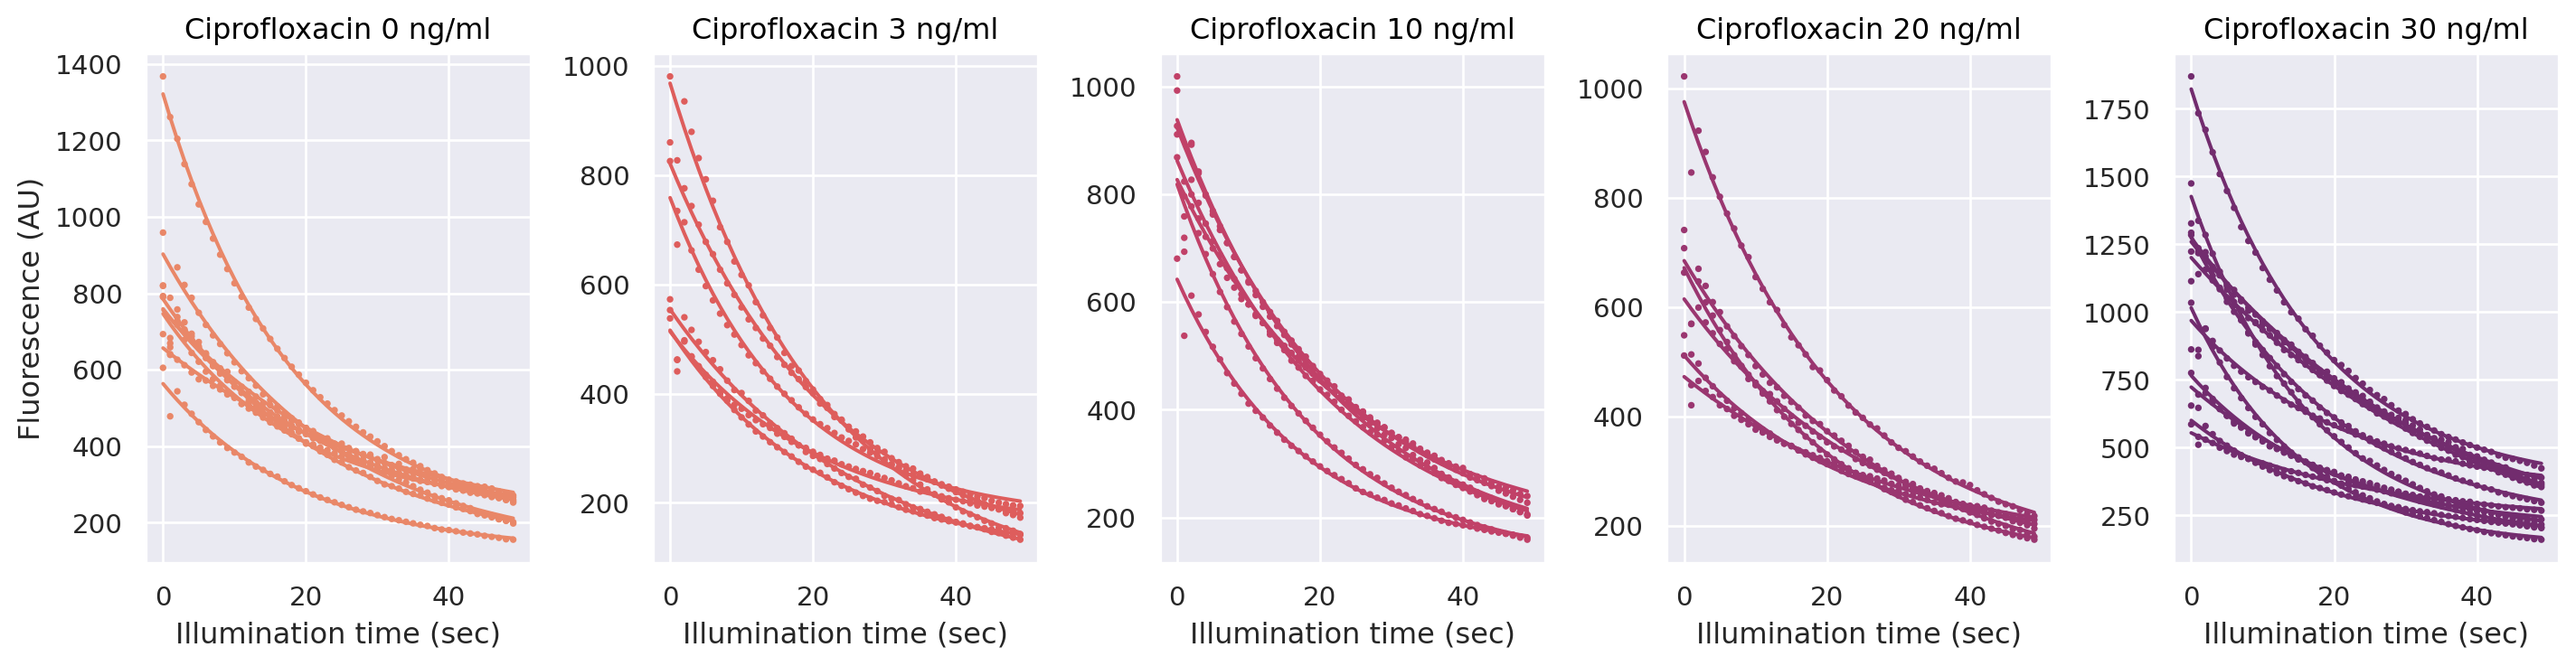

In [3]:
(
    so.Plot(bleaching_fit.data, x='Frame', color='Group', group='Dataset')
    .layout(size=(15, 4))
    .facet(col='Group')
    .add(so.Dots(marker='.', fillalpha=1), so.Agg(), y='SNR', legend=False)
    .add(so.Line(linestyle='-'), y='Fit', legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(x=(None, None), y=(None, None))
    .label(x="Illumination time (sec)", y="Fluorescence (AU)", color='', title='Ciprofloxacin {}'.format)
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Bleaching_fits.svg', format='svg', bbox_inches='tight')
)

Show fitted parameters

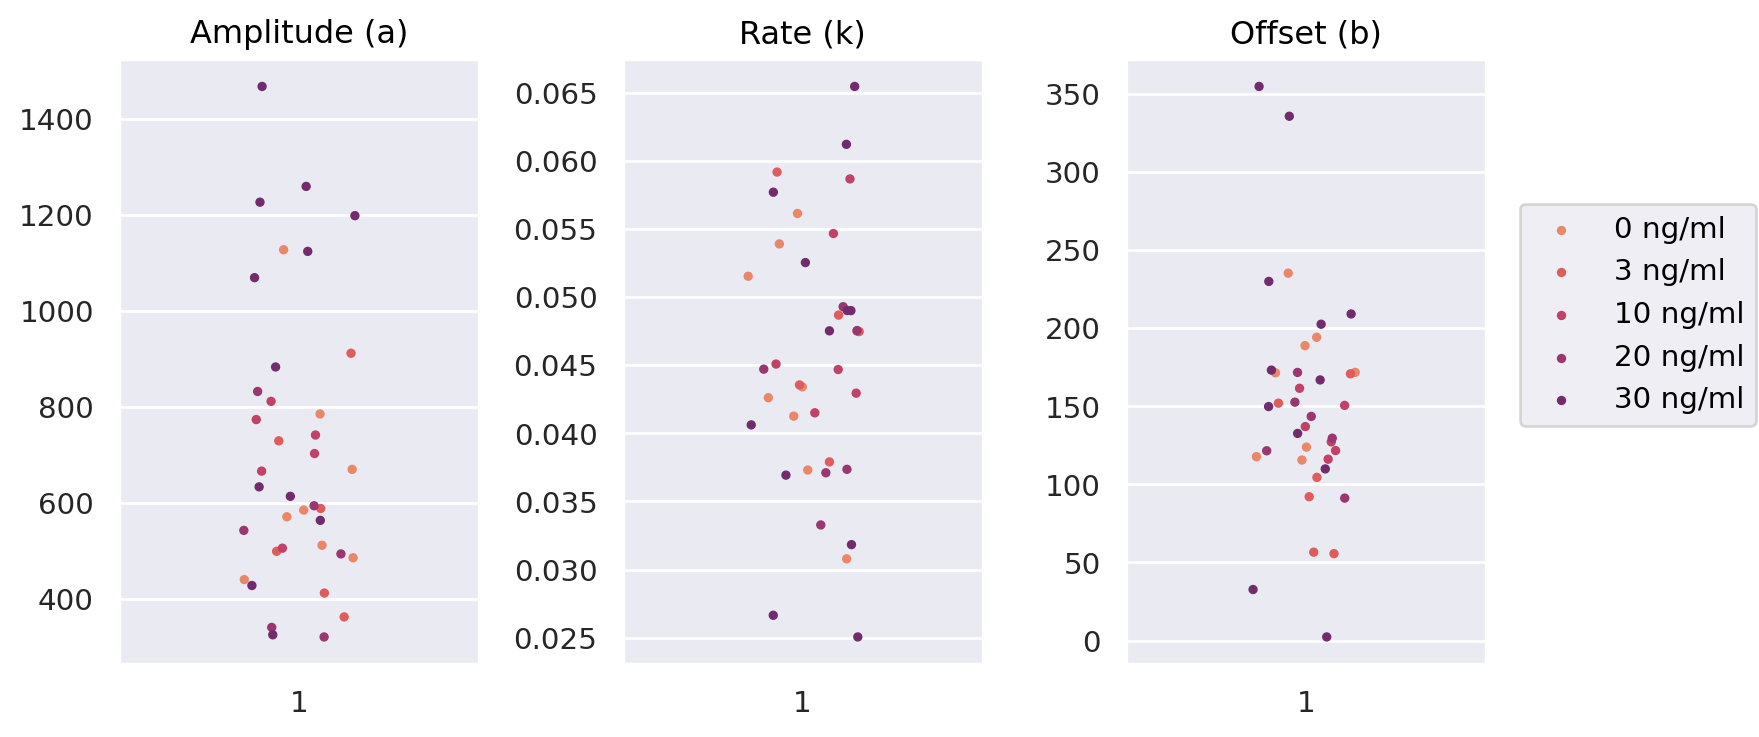

In [42]:
df = bleaching_fit.parameters.assign(x=lambda df: '1').replace({'offset':'Offset (b)', 'Amplitude':'Amplitude (a)', 'Rate':'Rate (k)'})

(
    so.Plot(df, x='x', y='Value', color='Group')
    .facet(col='Parameter')
    .layout(size=(8, 4))
    # .add(so.Dash(), so.Agg(), legend=False)
    .add(so.Dot(marker='.'), so.Jitter(.4))
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x='', y='', color='')
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Bleaching_parameters.svg', format='svg', bbox_inches='tight')
)

## RecB binding time on DNA

### A mono-exponential decay model does not fit the histograms well (especially under higher ciprofloxacin)

In [3]:
hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Group', 'Dataset'],
                     density=True, discrete=False, binlabels='left')                     
monoexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='monoexp_decay',
                   groupby=['Group', 'Dataset'], p0=[1, 0.1])

Show the fits

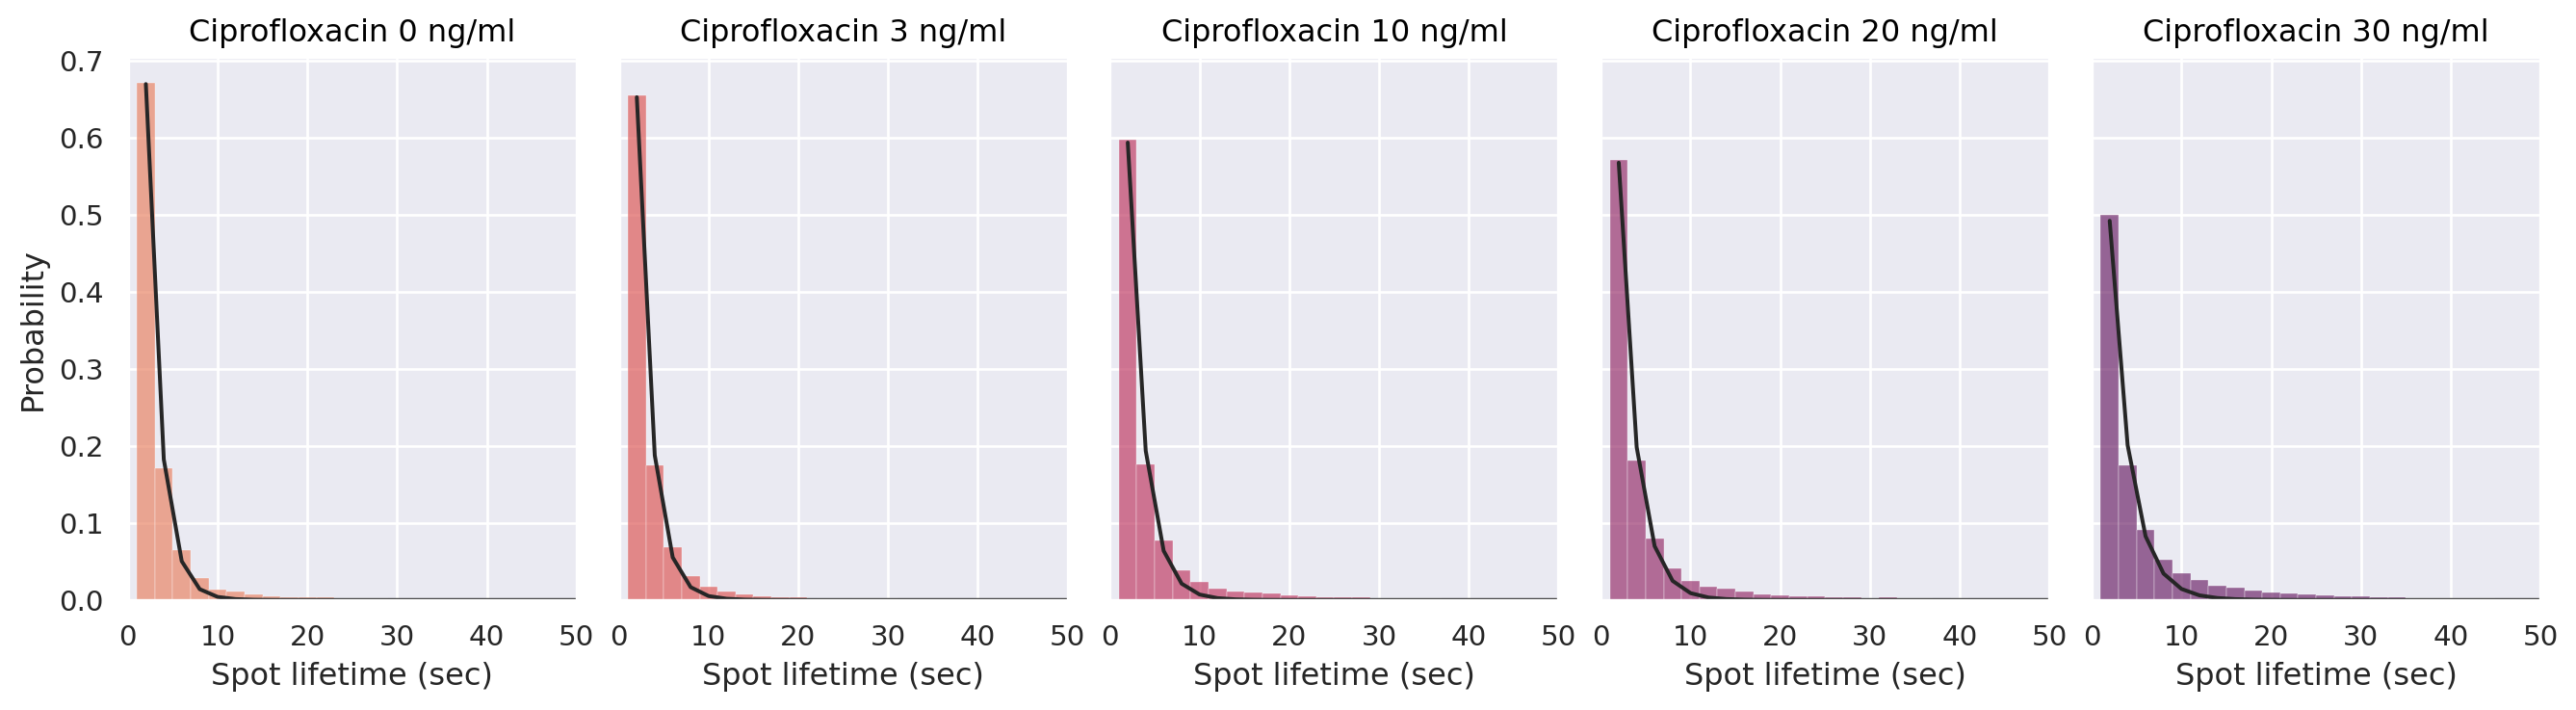

In [10]:
df = (monoexp_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      )

(
    so.Plot(df, x='TrackLength_s', color='Group')
    .layout(size=(14, 4))
    .facet(col='Group')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 50), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Monoexp_fits_cipro_A.svg', format='svg', bbox_inches='tight')
)

Zooming on the tail of the histograms emphasises how a mono-exponential decay is not a good fit

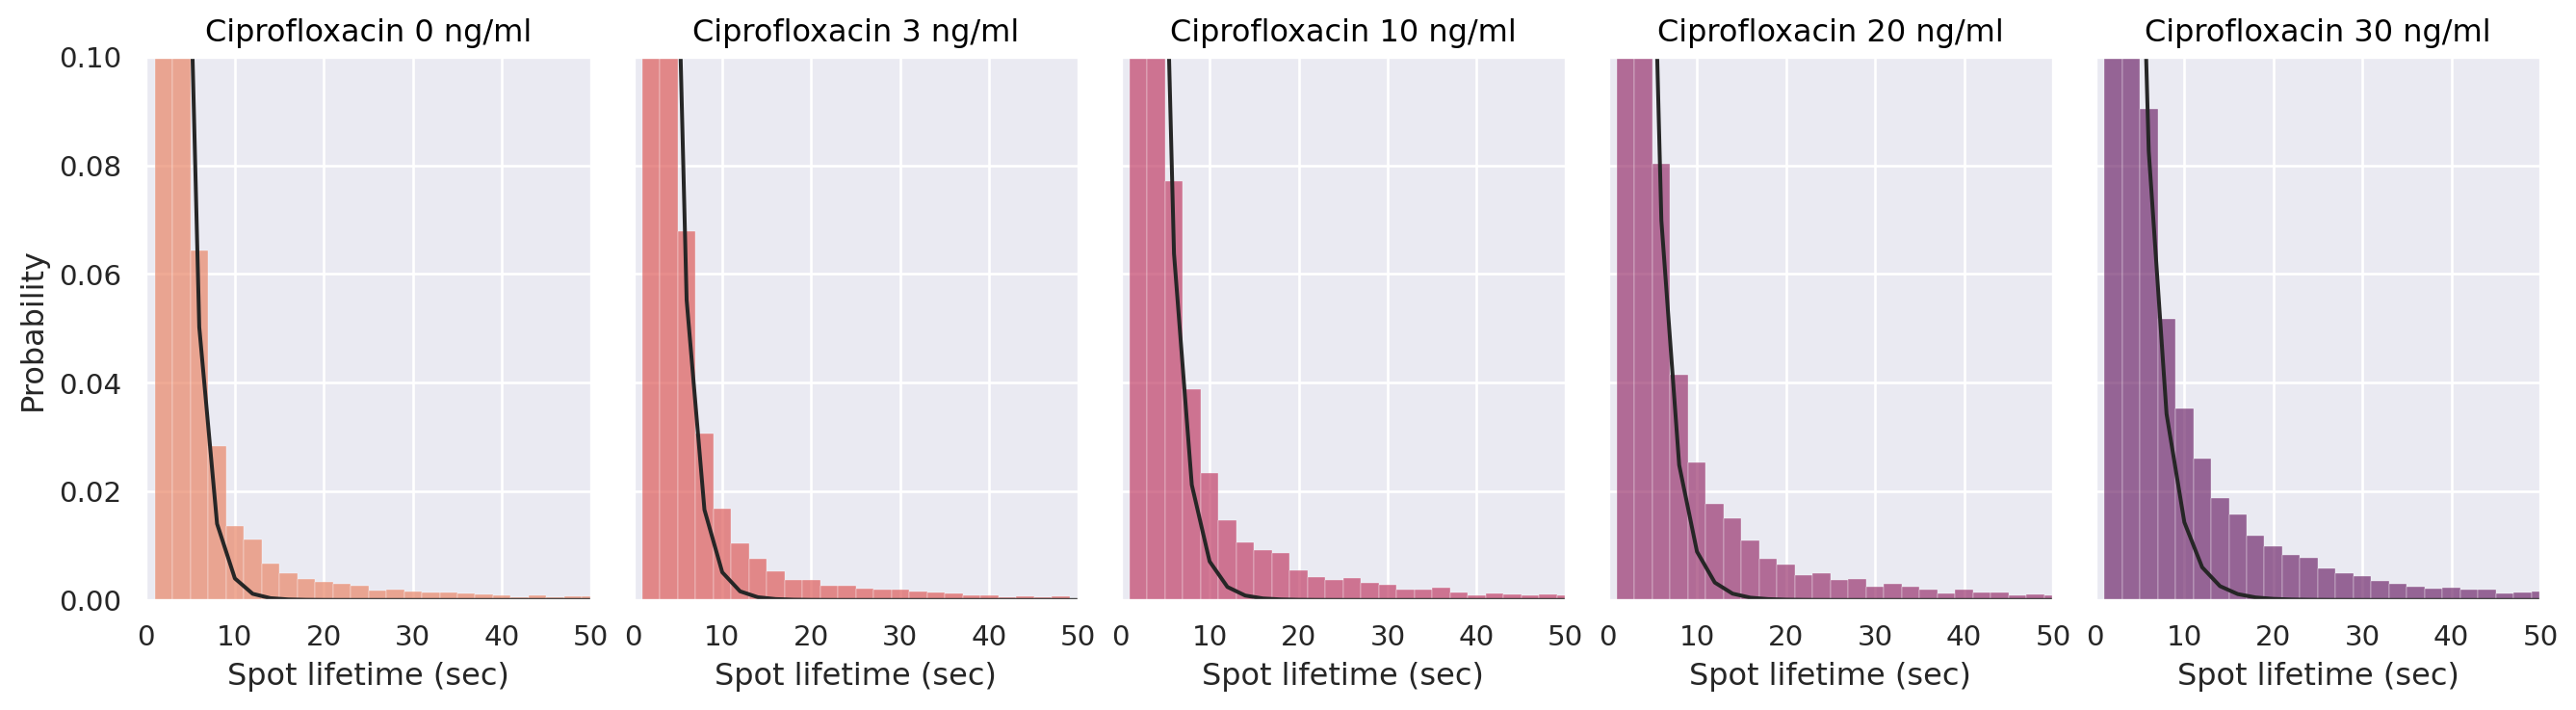

In [11]:
df = (monoexp_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      )

(
    so.Plot(df, x='TrackLength_s', color='Group')
    .layout(size=(14, 4))
    .facet(col='Group')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 50), y=(None, 0.1))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Monoexp_fits_cipro_B.svg', format='svg', bbox_inches='tight')
)

### Fitting with a bi-exponential model gives better results

Bootstrapping helps eliminate random variations by performing each fit 100 times, and taking the median fitted value for each parameter.

In [3]:
from pyberries.data import get_model

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Group', 'Dataset'],
                     density=True, discrete=False, binlabels='left')                     
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay', bootstrap_samples=100,
                   groupby=['Group', 'Dataset'], p0=[1, 1, 0.1, 0.1])

monoexp_decay = get_model('monoexp_decay')

lifetime_fit.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for ds, df in lifetime_fit.data.groupby('Dataset'):
    params = lifetime_fit.parameters.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    lifetime_fit.data.loc[lifetime_fit.data.Dataset == ds,:] = df

/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/da

Show the fits (with monoexponential components)

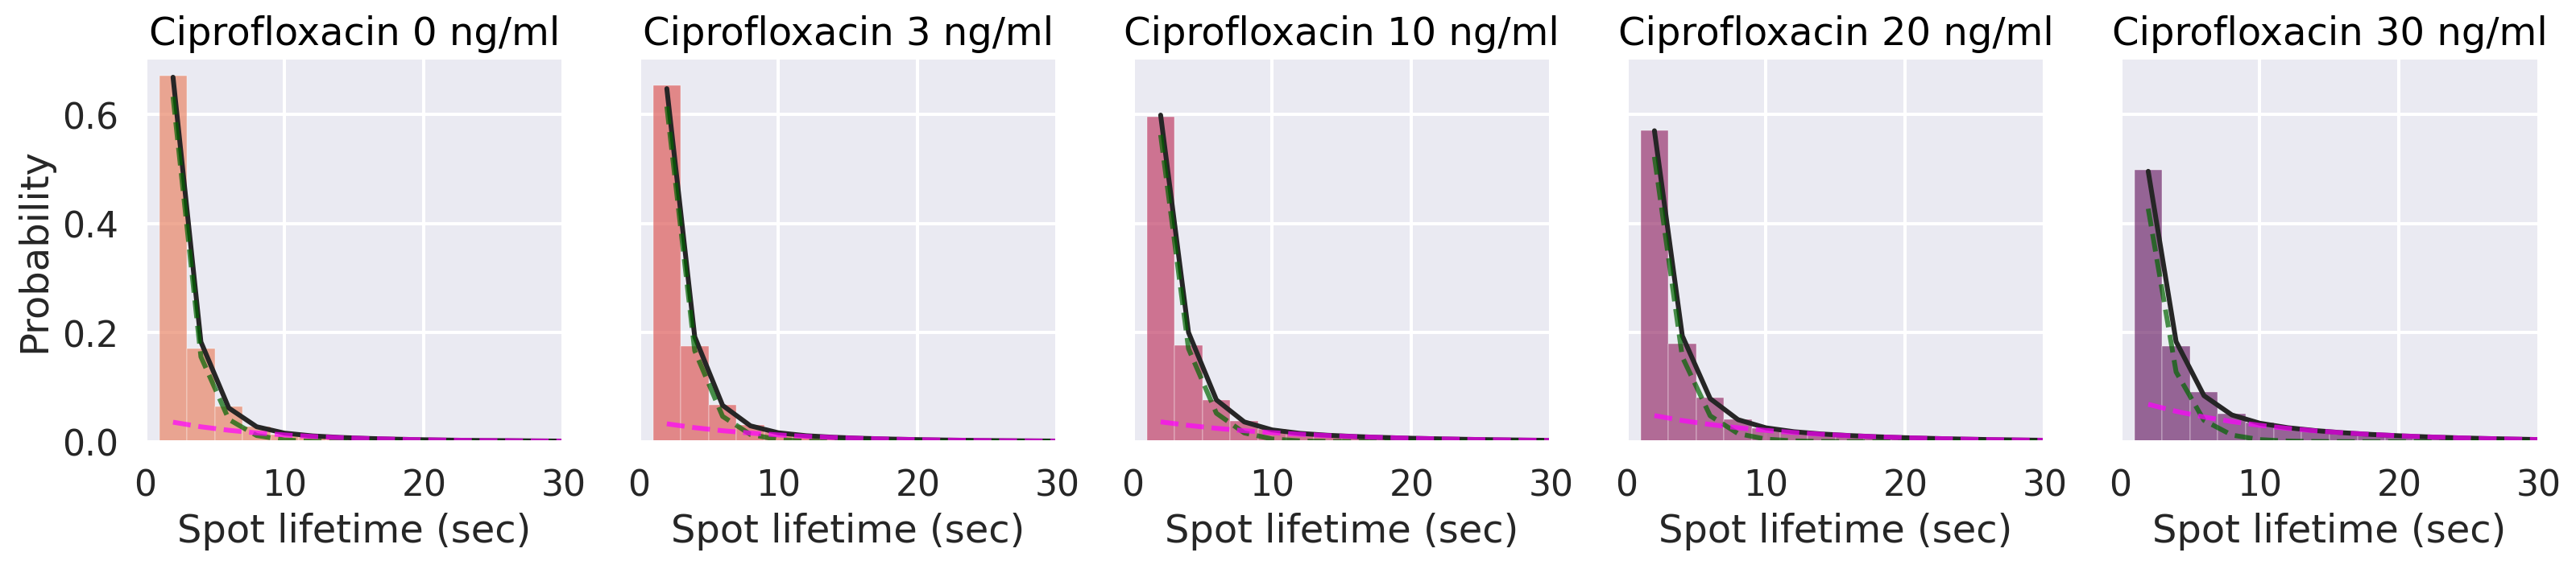

In [11]:
df = (lifetime_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
    #   .query('Group != "0 ng/ml"')
      )

(
    so.Plot(df, x='TrackLength_s', color='Group')
    .layout(size=(17, 4))
    .facet(col='Group')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    .theme(plotting_context('talk'))
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/RecB_lifetimes_fits.svg', format='svg', bbox_inches='tight')
)

Calculate spot lifetimes by taking into account the frame time (2 sec) and bleaching rates

Calculate Short- and Long-lived populations from the fit amplitudes

In [4]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes = (lifetime_fit
             .parameters
             .copy()
             .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
             .replace({'1':'Short', '2':'Long'})
             .merge(bleaching_rates[['Dataset', 'Value']], on='Dataset', suffixes=(None, '_bleaching'))
             .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Dataset', 'Value_bleaching'], columns=['Parameter', 'Rate_type']))
             .reset_index()
             .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - df.Value_bleaching) *2,
                     Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - df.Value_bleaching) *2,
                     Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                     Population_Short=lambda df: 100 - df.Population_Long
                     )
             .drop(columns=['Value', 'Value_bleaching'], level=0)
             .droplevel(['Parameter', 'Rate_type'], axis=1)
             .melt(id_vars=['Group', 'Dataset'])
             .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
             .drop(columns='variable')
             .assign(Group=lambda df: df.Group
                                        .astype('category')
                                        .cat.set_categories(['0 ng/ml', '3 ng/ml', '10 ng/ml', '20 ng/ml', '30 ng/ml'], ordered=True))
             .sort_values('Group')
             )

Spot lifetimes (both short and long-lived spots)

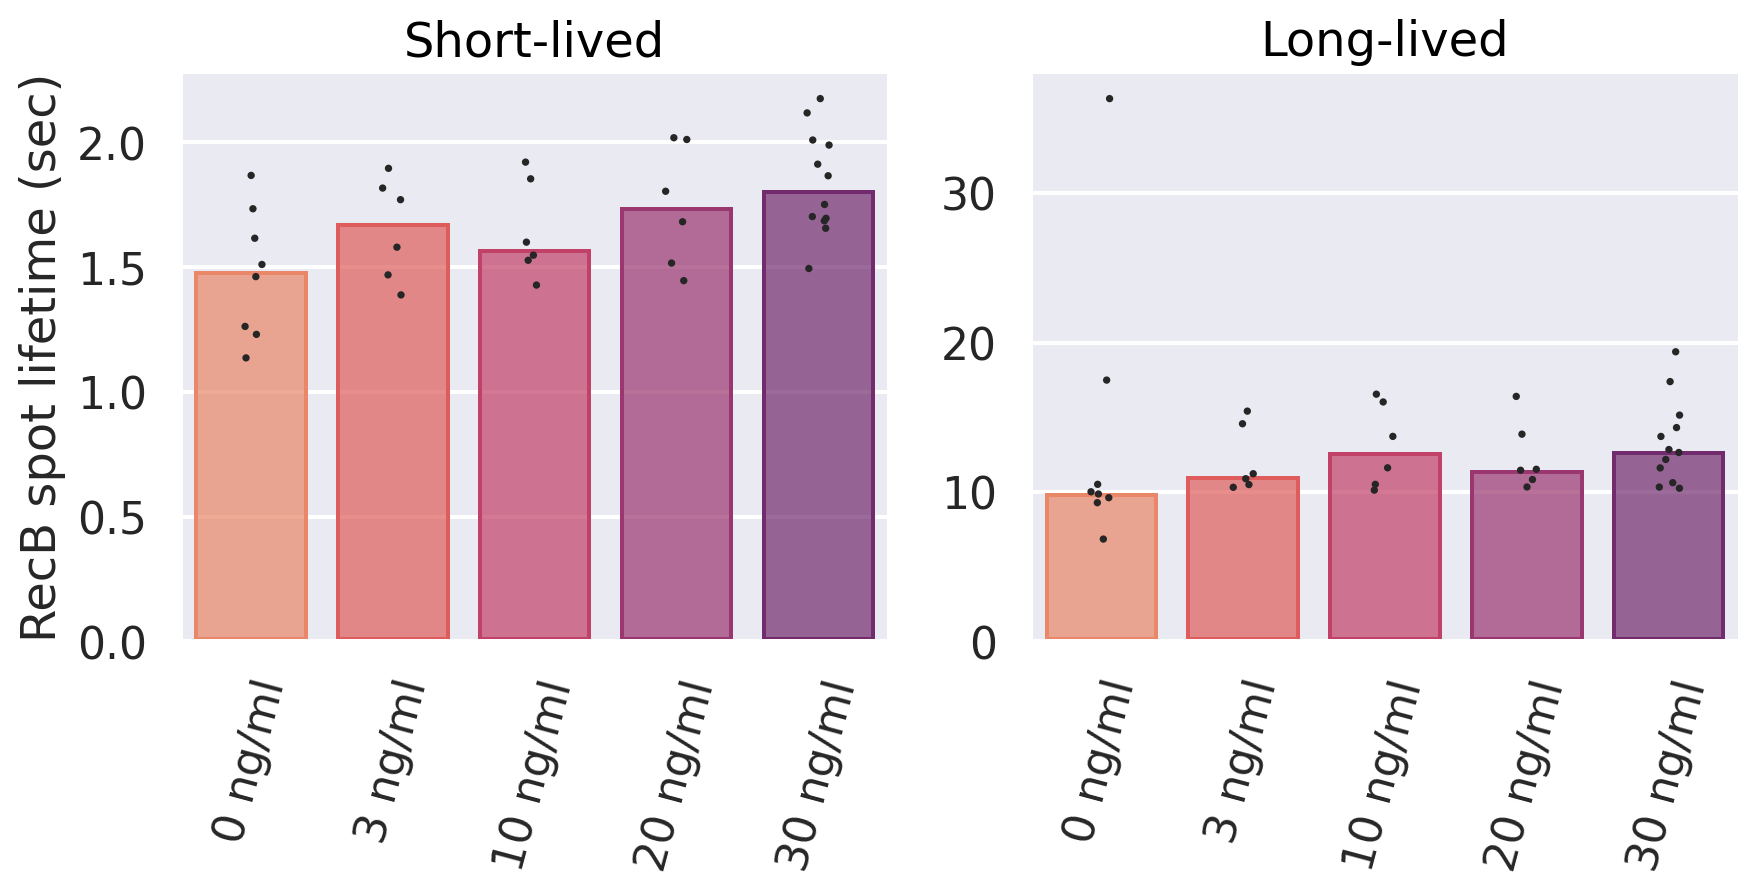

In [5]:
p = (
    so.Plot(lifetimes.query('Parameter == "Lifetime"'), x='Group', y='value', color='Group')
    .layout(size=(9.5,5))
    .facet(col='Rate_type')
    .add(so.Bar(), so.Agg('median'), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color=so.Nominal('flare'))
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="RecB spot lifetime (sec)", color='Ciprofloxacin', title='{}-lived'.format)
    .theme(plotting_context('talk'))
    .plot()
)

p._figure.axes[0].xaxis.set_tick_params(rotation=75)
p._figure.axes[1].xaxis.set_tick_params(rotation=75)

display(p)
# p.save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')

Proportion of long-lived spots

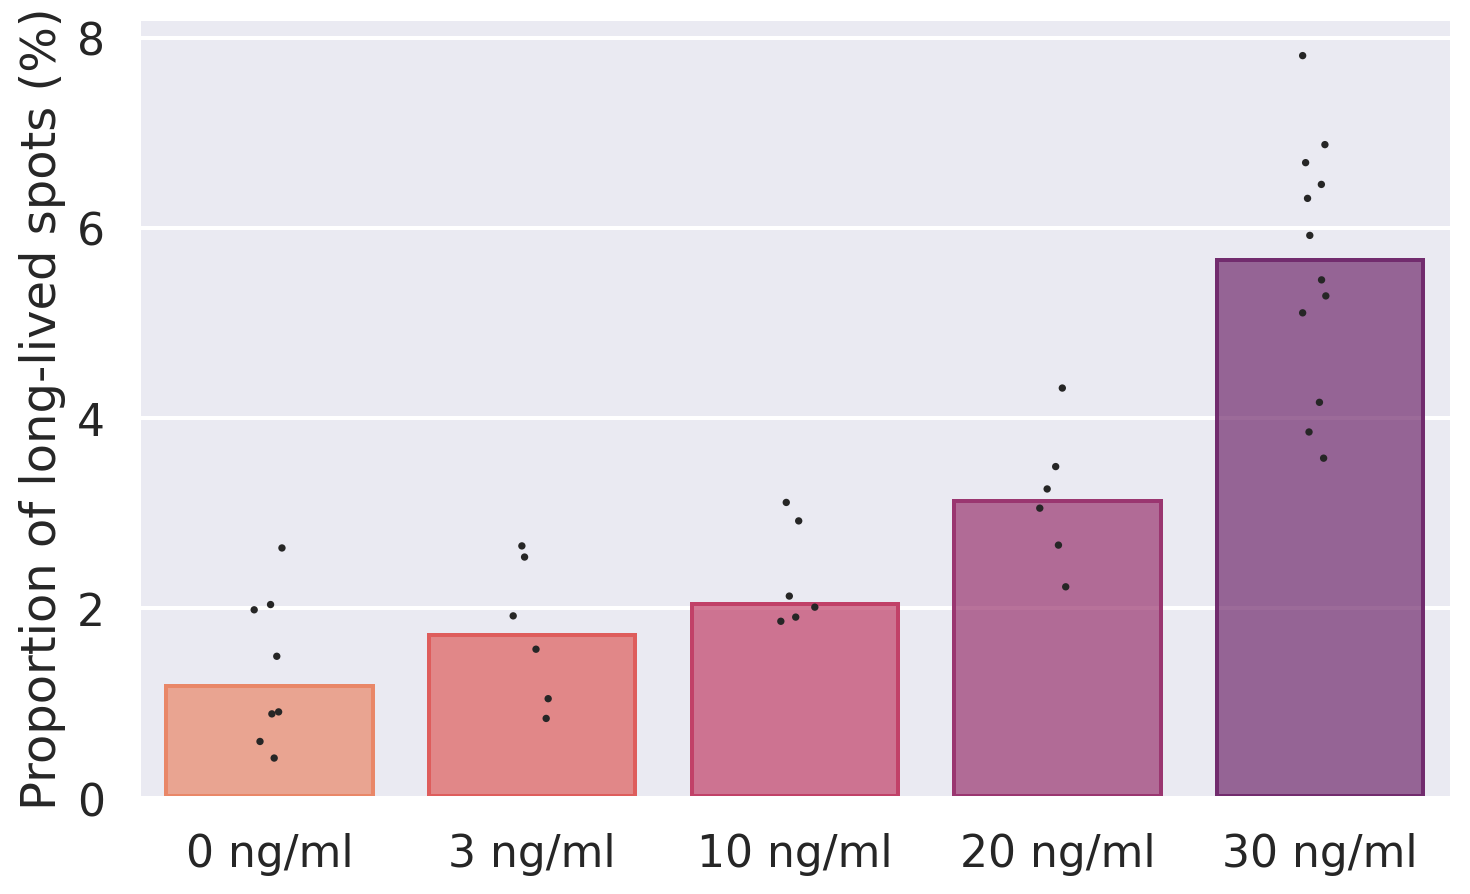

In [12]:
df = (lifetimes
      .query('Parameter == "Population" and Rate_type == "Long"')
      .assign(value=lambda df: df.value)
      )

(
    so.Plot(df, x='Group', y='value', color='Group')
    .layout(size=(8,5))
    .add(so.Bar(), so.Agg('median'), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(0, None))
    .label(x="", y="Proportion of long-lived spots (%)", color='Ciprofloxacin')
    .theme(plotting_context('talk'))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Proportion_long_spots.svg', format='svg', bbox_inches='tight')
)

#### Estimate of the rate of RecB recruitment to DNA

We can estimate the rate of recruitment of RecB to DNA by counting how many long-lived spots appear (on average per dataset) over our 100 sec timelapse.

See further below for an estimate of recruitment rate at different time-points post ciprofloxacin exposure.

recruitment_rate     
                median  std
Group                      
0                  1.3  1.1
3                  1.8  2.2
10                 3.8  1.4
20                 4.1  1.7
30                 8.2  3.6

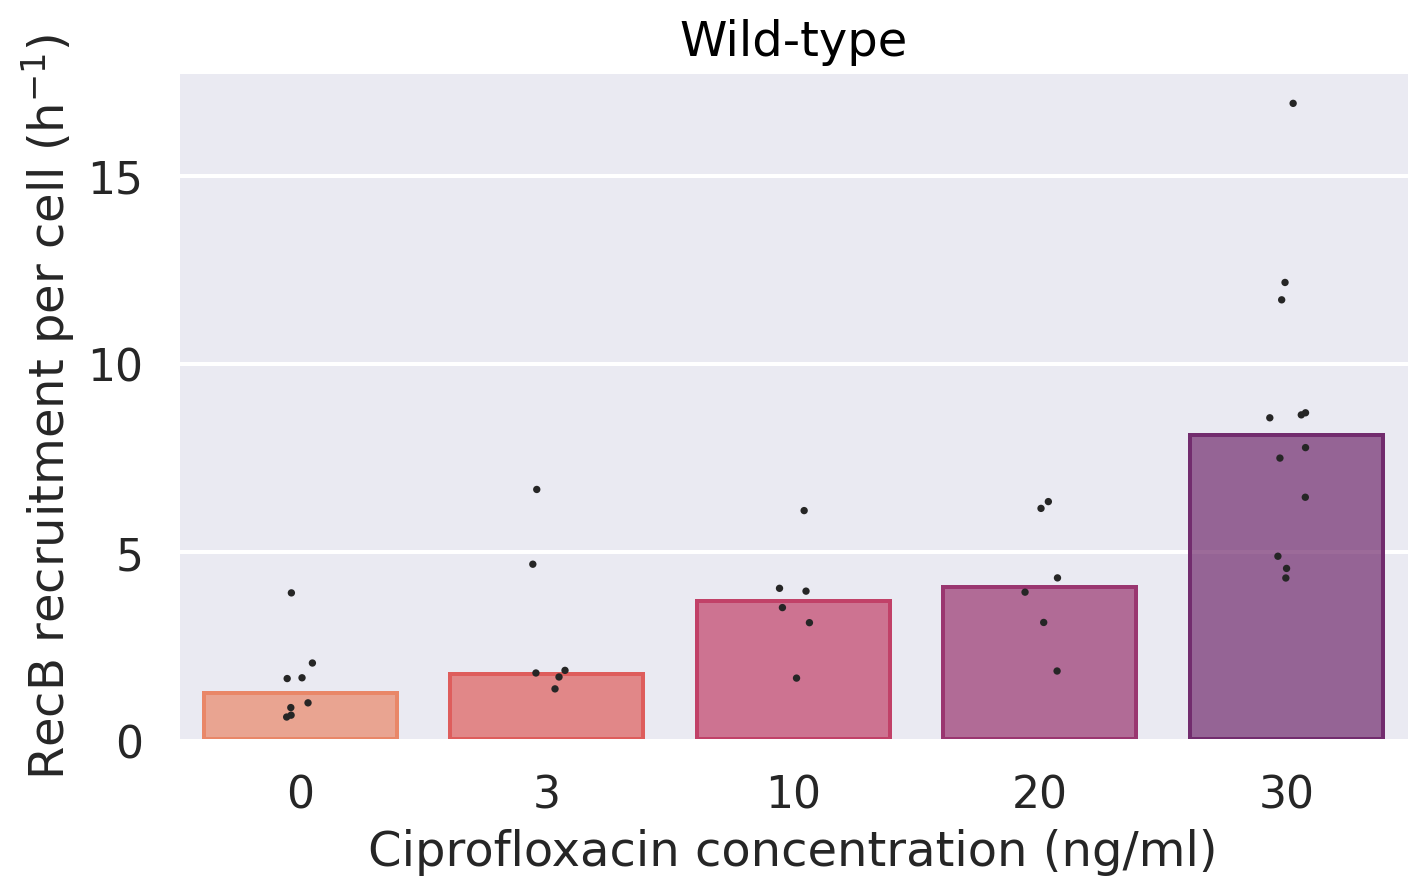

In [19]:
df = (data
      .RecB_spots
      .query('Time_min_bin <= 30 and Frame > 0')
      .groupby(by=['Group', 'Dataset', 'ParentIndices'], observed=True)
      .agg({'Indices': 'count'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .groupby(by=['Group', 'Dataset'], observed=True)
      .agg({'SpotCount': 'sum'})
      .reset_index()
      .merge(data
             .Bacteria_large
             .query('Time_min_bin <= 30 and Frame > 0')
             .groupby(['Dataset'], observed=True)
             .agg({'Position':'count'})
             .reset_index()
             .rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset'],
             suffixes=('_old', None)
             )
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.SpotCount / df.nCells
              )
      .merge(lifetimes  # Retrieve the proportion of long-lived spots from fits
             .query('Parameter == "Population" and Rate_type == "Long"')
             .rename(columns={'value':'long_lived'})
             .assign(long_lived=lambda df: (df.long_lived)/100),
             on=['Group', 'Dataset']
             )
      .merge(bleaching_fit.data  # Retrieve the average "labelling efficiency" over the timelapse
             .groupby('Dataset')
             .agg(efficiency=('Fit', lambda x: x.mean()/x.iloc[0])),
             on='Dataset'
             )
      .assign(recruitment_rate=lambda df: df.norm_count / 98*60*60 *df.long_lived / df.efficiency,  # Rate of DSB formation (h-1)
              Group=lambda df: df.Group.str.replace(' ng/ml','')
              )
      )

display(df
        .assign(Group=lambda df: df.Group
                                   .astype('category')
                                   .cat.set_categories(['0', '3', '10', '20', '30'], ordered=True))
        .sort_values('Group')
        .groupby('Group', observed=True)
        .agg({'recruitment_rate':['median', 'std']})
        .round(1)
        )

(
    so.Plot(df, x='Group', y='recruitment_rate', color='Group')
    .layout(size=(8,5))
    .add(so.Bar(), so.Agg('median'), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color=so.Nominal('flare', order=['0', '3', '10', '20', '30']),
           x=so.Nominal(order=['0', '3', '10', '20', '30'])
           )
    .share(y=False)
    .limit(y=(0, None))
    .label(x="Ciprofloxacin concentration (ng/ml)", y="RecB recruitment per cell (h$^{-1}$)", color='Ciprofloxacin', title="Wild-type")
    .theme(plotting_context('talk'))
#     .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/RecB_recruitment_rate.svg', format='svg', bbox_inches='tight')
)

Alternative version for poster

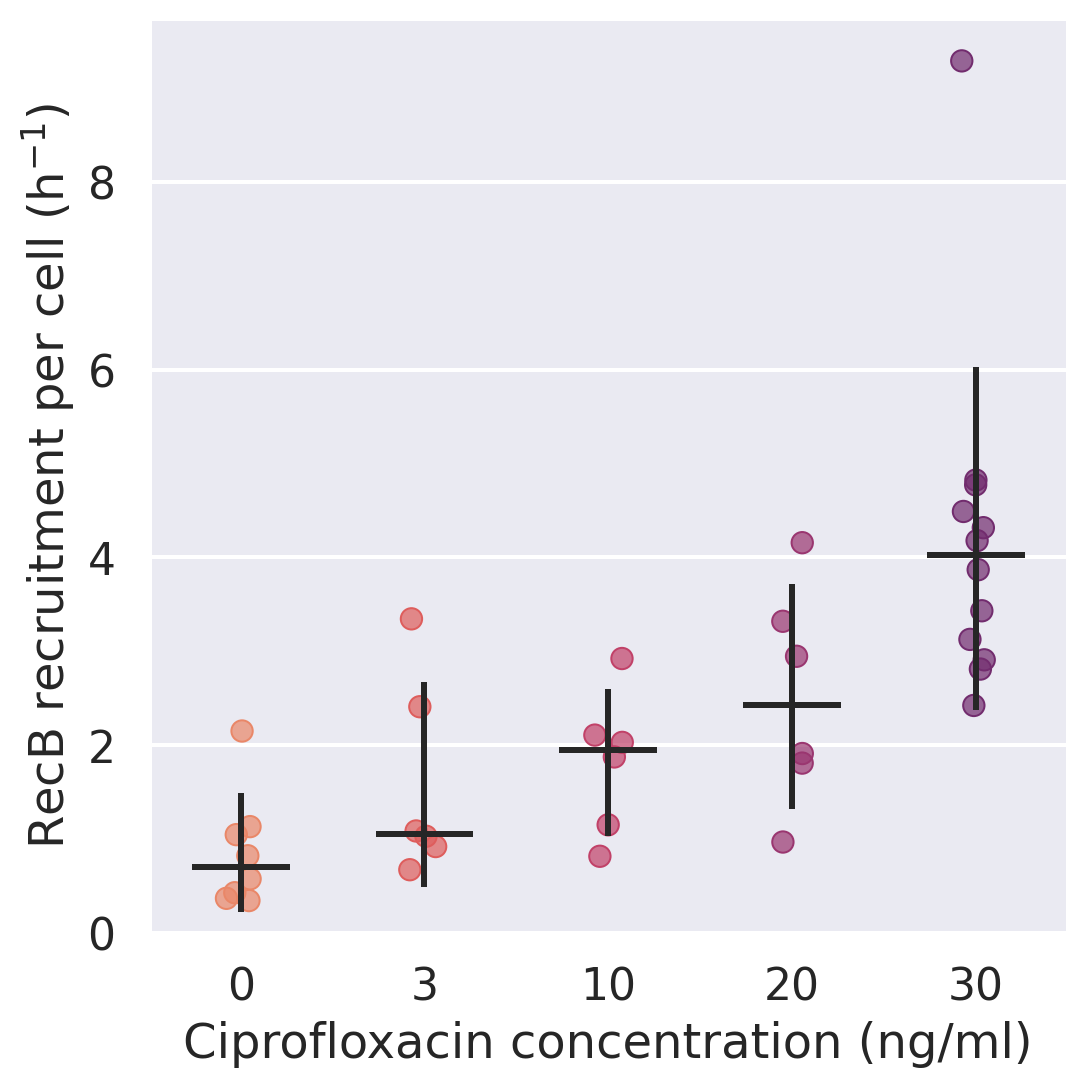

In [58]:
df = (data
      .RecB_spots
      .query('Time_min_bin <= 30 and Frame > 0')
      .groupby(by=['Group', 'Dataset', 'ParentIndices'], observed=True)
      .agg({'Indices': 'count'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .groupby(by=['Group', 'Dataset'], observed=True)
      .agg({'SpotCount': 'sum'})
      .reset_index()
      .merge(data
             .Bacteria_large
             .query('Time_min_bin <= 30 and Frame > 0')
             .groupby(['Dataset'], observed=True)
             .agg({'Position':'count'})
             .reset_index()
             .rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset'],
             suffixes=('_old', None)
             )
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.SpotCount / df.nCells
              )
      .merge(lifetimes
             .query('Parameter == "Population" and Rate_type == "Long"')
             .rename(columns={'value':'long_lived'})
             .assign(long_lived=lambda df: (df.long_lived)/100),
             on=['Group', 'Dataset']
             )
      .assign(DSB_rate=lambda df: df.norm_count /98*60*60 *df.long_lived)  # Rate of DSB formation (h-1)
      .assign(Group=lambda df: df.Group.str.replace(' ng/ml', ''))
      )

(
    so.Plot(df, x='Group', y='DSB_rate', color='Group')
    .layout(size=(6,6))
    .add(so.Dash(width=.5, color='k'), so.Agg('median'), legend=False)
    .add(so.Range(color='k'), so.Est(errorbar='sd'), legend=False)
    .add(so.Dots(marker='o', pointsize=8, fillalpha=0.7), so.Jitter(), legend=False)
    .scale(color=so.Nominal('flare', order=['0', '3', '10', '20', '30']),
           x=so.Nominal(order=['0', '3', '10', '20', '30'])
           )
    .share(y=False)
    .limit(y=(0, None))
    .label(x="Ciprofloxacin concentration (ng/ml)", y="RecB recruitment per cell (h$^{-1}$)", color='Ciprofloxacin')
    .theme(plotting_context('talk'))
#     .save(loc='/media/daniel/HDD Daniel/DanielThedie/Posters/I2K_2024/RecB_recruitment_rate.svg', format='svg', bbox_inches='tight')
)

Fit parameters table

In [26]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Group', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Group', 'Rate_type'], observed=True)
      .agg(Lifetime_median=('Lifetime', 'median'),
           Lifetime_std=('Lifetime', 'std'),
           Population_median=('Population', 'median'),
           Population_std=('Population', 'std')
           )
      .round(1)
      .pipe(lambda df: fuse_cols(df, cols=['Lifetime_median', 'Lifetime_std'], new='Lifetime (sec)', delimiter=' $\pm$ '))
      .pipe(lambda df: fuse_cols(df, cols=['Population_median', 'Population_std'], new='Population (\%)', delimiter=' $\pm$ '))
      [['Lifetime (sec)', 'Population (\%)']]
      .rename_axis(['Ciprofloxacin', 'Type'])
      .reindex(['Short', 'Long'], level=1)
      )

display(df)
print(df.to_latex())

Lifetime (sec) Population (\%)
Ciprofloxacin Type                                 
0 ng/ml       Short   1.5 $\pm$ 0.2  98.6 $\pm$ 0.9
              Long    9.8 $\pm$ 9.1   1.4 $\pm$ 0.9
3 ng/ml       Short   1.6 $\pm$ 0.3  98.1 $\pm$ 0.8
              Long   10.7 $\pm$ 2.5   1.9 $\pm$ 0.8
10 ng/ml      Short   1.6 $\pm$ 0.2  97.7 $\pm$ 0.7
              Long   13.0 $\pm$ 2.7   2.3 $\pm$ 0.7
20 ng/ml      Short   1.8 $\pm$ 0.2  96.9 $\pm$ 0.8
              Long   12.0 $\pm$ 2.1   3.1 $\pm$ 0.8
30 ng/ml      Short   1.8 $\pm$ 0.3  94.8 $\pm$ 1.3
              Long   13.3 $\pm$ 2.5   5.2 $\pm$ 1.3

\begin{tabular}{llll}
\toprule
 &  & Lifetime (sec) & Population (\%) \\
Ciprofloxacin & Type &  &  \\
\midrule
\multirow[t]{2}{*}{0 ng/ml} & Short & 1.5 $\pm$ 0.2 & 98.6 $\pm$ 0.9 \\
 & Long & 9.8 $\pm$ 9.1 & 1.4 $\pm$ 0.9 \\
\cline{1-4}
\multirow[t]{2}{*}{3 ng/ml} & Short & 1.6 $\pm$ 0.3 & 98.1 $\pm$ 0.8 \\
 & Long & 10.7 $\pm$ 2.5 & 1.9 $\pm$ 0.8 \\
\cline{1-4}
\multirow[t]{2}{*}{10 ng/ml} & Short & 1.6 $\pm$ 0.2 & 97.7 $\pm$ 0.7 \\
 & Long & 13.0 $\pm$ 2.7 & 2.3 $\pm$ 0.7 \\
\cline{1-4}
\multirow[t]{2}{*}{20 ng/ml} & Short & 1.8 $\pm$ 0.2 & 96.9 $\pm$ 0.8 \\
 & Long & 12.0 $\pm$ 2.1 & 3.1 $\pm$ 0.8 \\
\cline{1-4}
\multirow[t]{2}{*}{30 ng/ml} & Short & 1.8 $\pm$ 0.3 & 94.8 $\pm$ 1.3 \\
 & Long & 13.3 $\pm$ 2.5 & 5.2 $\pm$ 1.3 \\
\cline{1-4}
\bottomrule
\end{tabular}



### Fit timepoints independently by pooling datasets

The goal here is to fit the different time-points post ciprofloxacin exposure separately. Replicate datasets are pooled to increase statistics.

Bootstrapping was essential here so fits don't fall into local minima, producing inconsistent values.

In [10]:
from pyberries.data import get_model

hist = (get_histogram(data.RecB_spots.query('Time_min_bin < 90'), col='TrackLength', binsize=1, groupby=['Group', 'Time_min_bin'], density=True, discrete=False, binlabels='left')
        )
fit_timepoints = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                     bootstrap_samples=100,
                     groupby=['Group', 'Time_min_bin'], p0=[1, 1, 0.1, 0.1])


monoexp_decay = get_model('monoexp_decay')

fit_timepoints.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for grp, df in fit_timepoints.data.groupby(['Group', 'Time_min_bin']):
    cip, t = grp
    t = str(t)
    params = fit_timepoints.parameters.query('Time_min_bin == @t and Group == @cip')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    fit_timepoints.data.loc[(fit_timepoints.data.Time_min_bin == float(t)) & (fit_timepoints.data.Group == cip),:] = df

Group ('0 ng/ml', 30.0): 8 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('0 ng/ml', 45.0): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('0 ng/ml', 60.0): 5 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('0 ng/ml', 75.0): 29 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Group ('3 ng/ml', 15.0): 1 iterations failed
Group ('3 ng/ml', 60.0): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('3 ng/ml', 75.0): 4 iterations failed
Group ('10 ng/ml', 30.0): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('10 ng/ml', 45.0): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('20 ng/ml', 30.0): 2 iterations failed
Group ('20 ng/ml', 45.0): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('20 ng/ml', 60.0): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('30 ng/ml', 75.0): 3 iterations failed


In [11]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes_timepoints = (fit_timepoints
                        .parameters
                        .copy()
                        .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
                        .replace({'1':'Short', '2':'Long'})
                        .pipe(lambda df: pd.pivot_table(df, values=['Value', 'Error'], index=['Group', 'Time_min_bin'], columns=['Parameter', 'Rate_type']))
                        .reset_index()
                        .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - bleaching_rates.Value.mean()) *2,
                                Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - bleaching_rates.Value.mean()) *2,
                                Errormin_Short=lambda df: - 1/(df.Value.Rate.Short - bleaching_rates.Value.mean())**2 * df.Error.Rate.Short *2 + df.Lifetime_Short,
                                Errormax_Short=lambda df: 1/(df.Value.Rate.Short - bleaching_rates.Value.mean())**2 * df.Error.Rate.Short *2 + df.Lifetime_Short,
                                Errormin_Long=lambda df: - 1/(df.Value.Rate.Long - bleaching_rates.Value.mean())**2 * df.Error.Rate.Long *2 + df.Lifetime_Long,
                                Errormax_Long=lambda df: 1/(df.Value.Rate.Long - bleaching_rates.Value.mean())**2 * df.Error.Rate.Long *2 + df.Lifetime_Long,
                                Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                                Population_Short=lambda df: 100 - df.Population_Long
                                )
                        .drop(columns=['Value', 'Error'], level=0)
                        .droplevel(['Parameter', 'Rate_type'], axis=1)
                        .melt(id_vars=['Group', 'Time_min_bin'])
                        .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
                        .drop(columns='variable')
                        .pipe(lambda df: pd.pivot_table(df, values=['value'], index=['Group', 'Time_min_bin', 'Rate_type'], columns=['Parameter']))
                        .droplevel(0, axis=1)
                        .reset_index()
                        .assign(Group=lambda df: df.Group
                                                   .astype('category')
                                                   .cat.set_categories(['0 ng/ml', '3 ng/ml', '10 ng/ml', '20 ng/ml', '30 ng/ml'], ordered=True),
                                Time_min_bin=lambda df: df.Time_min_bin.astype('float'),
                                Rate_type=lambda df: df.Rate_type + '-lived'
                                )
                        .sort_values('Group')
                        )

#### RecB spot lifetimes

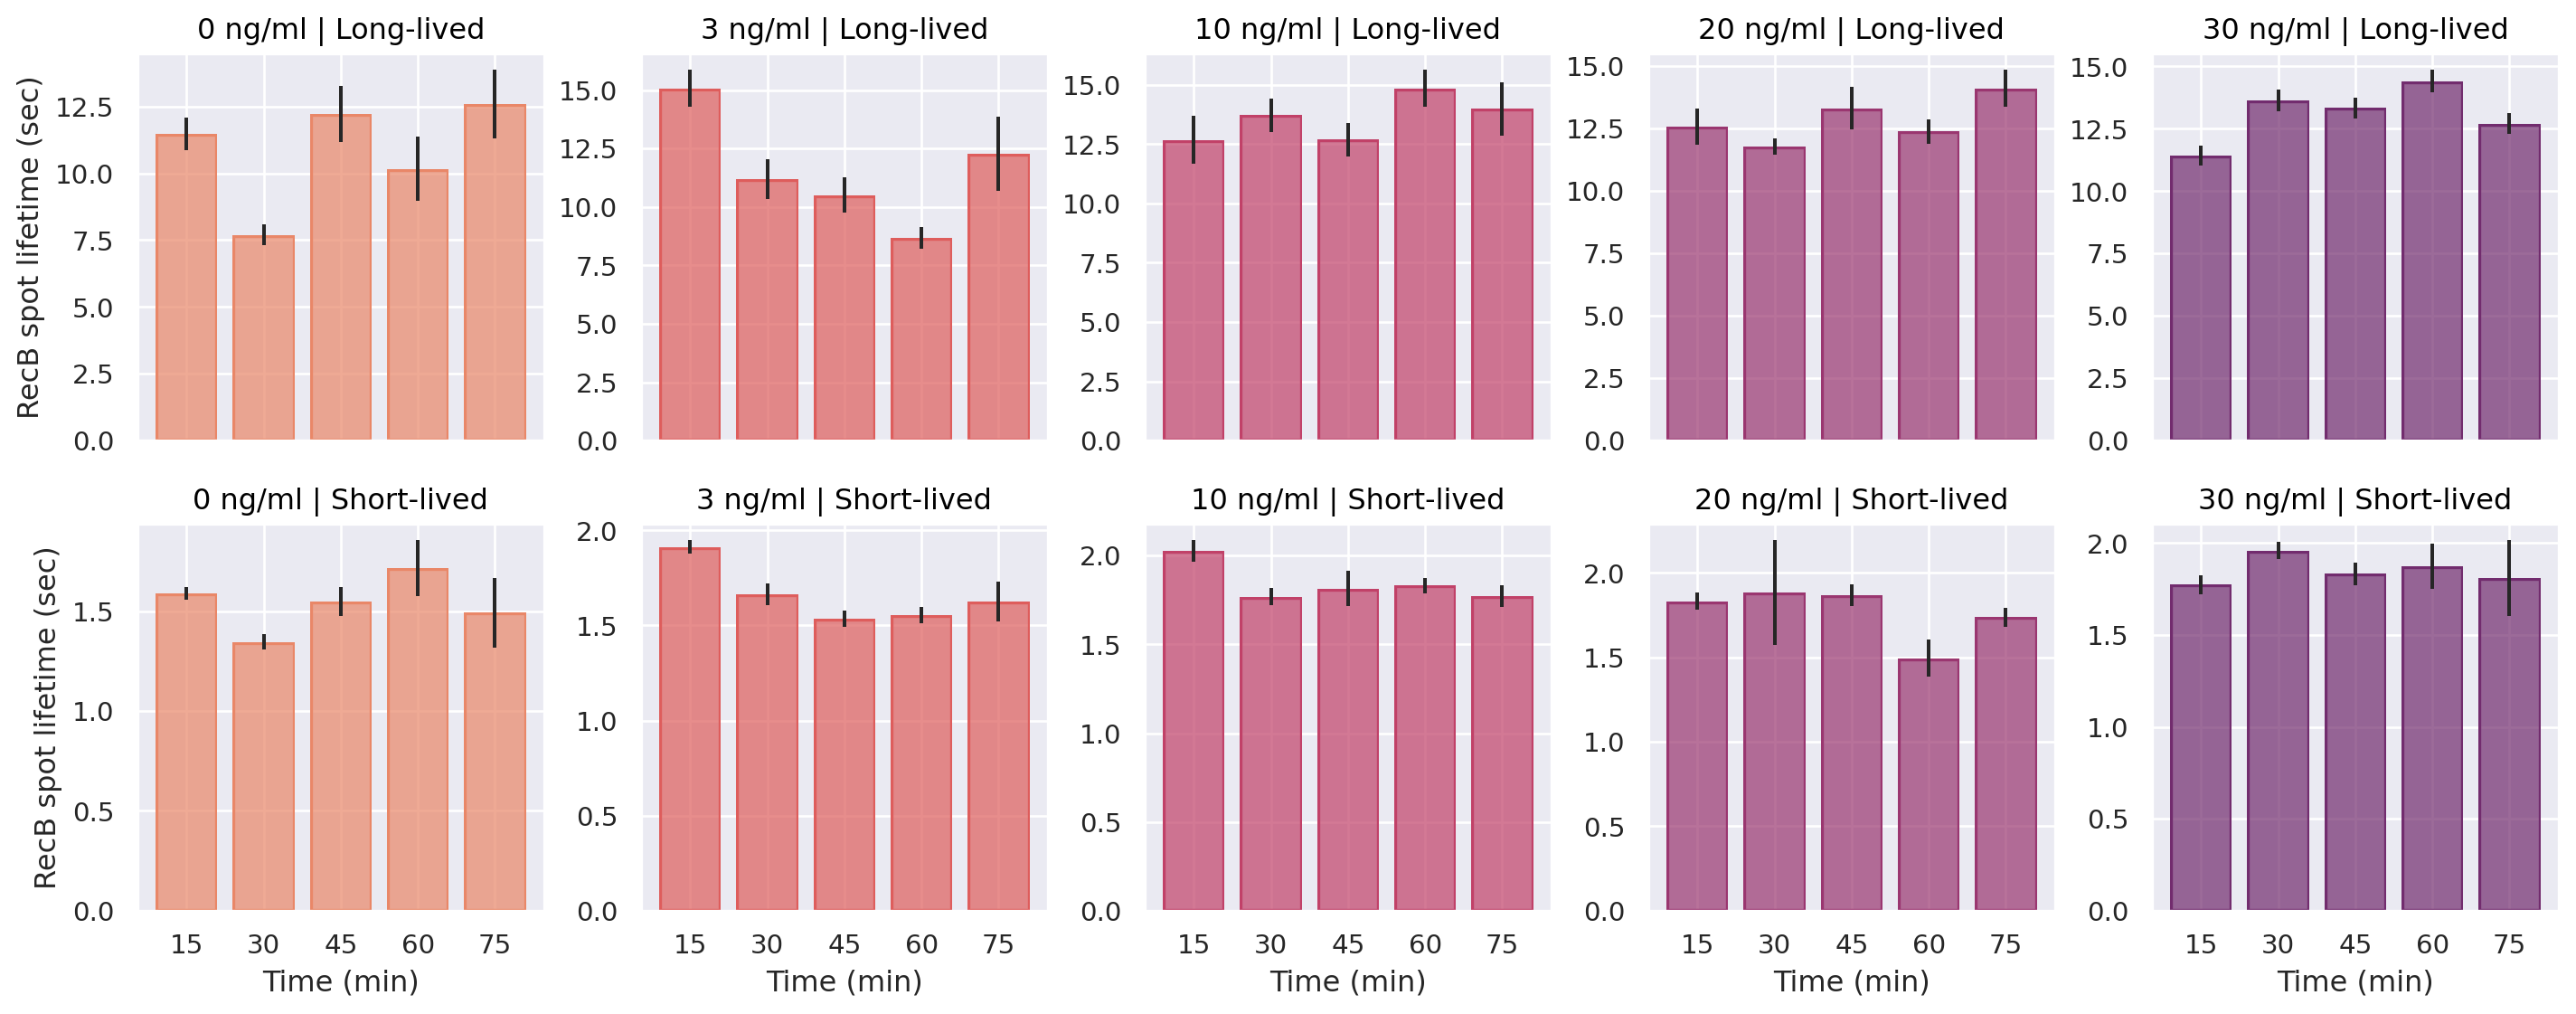

In [12]:
(
    so.Plot(lifetimes_timepoints, x='Time_min_bin', y='Lifetime', ymin='Errormin', ymax='Errormax', color='Group')
    .layout(size=(15, 6))
    .facet(row='Rate_type', col='Group')
    .add(so.Bar(), so.Agg(), legend=False)
    .add(so.Range(color='k'), legend=False)
    .scale(color=so.Nominal('flare'), x=so.Continuous().tick(every=15))
    .share(y=False)
    .limit(y=(None, None))
    .label(x="Time (min)", y="RecB spot lifetime (sec)", color='Ciprofloxacin')
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/RecB_lifetime_timepoints.pdf', format='pdf', bbox_inches='tight')
)

#### Proportion of long-lived spots

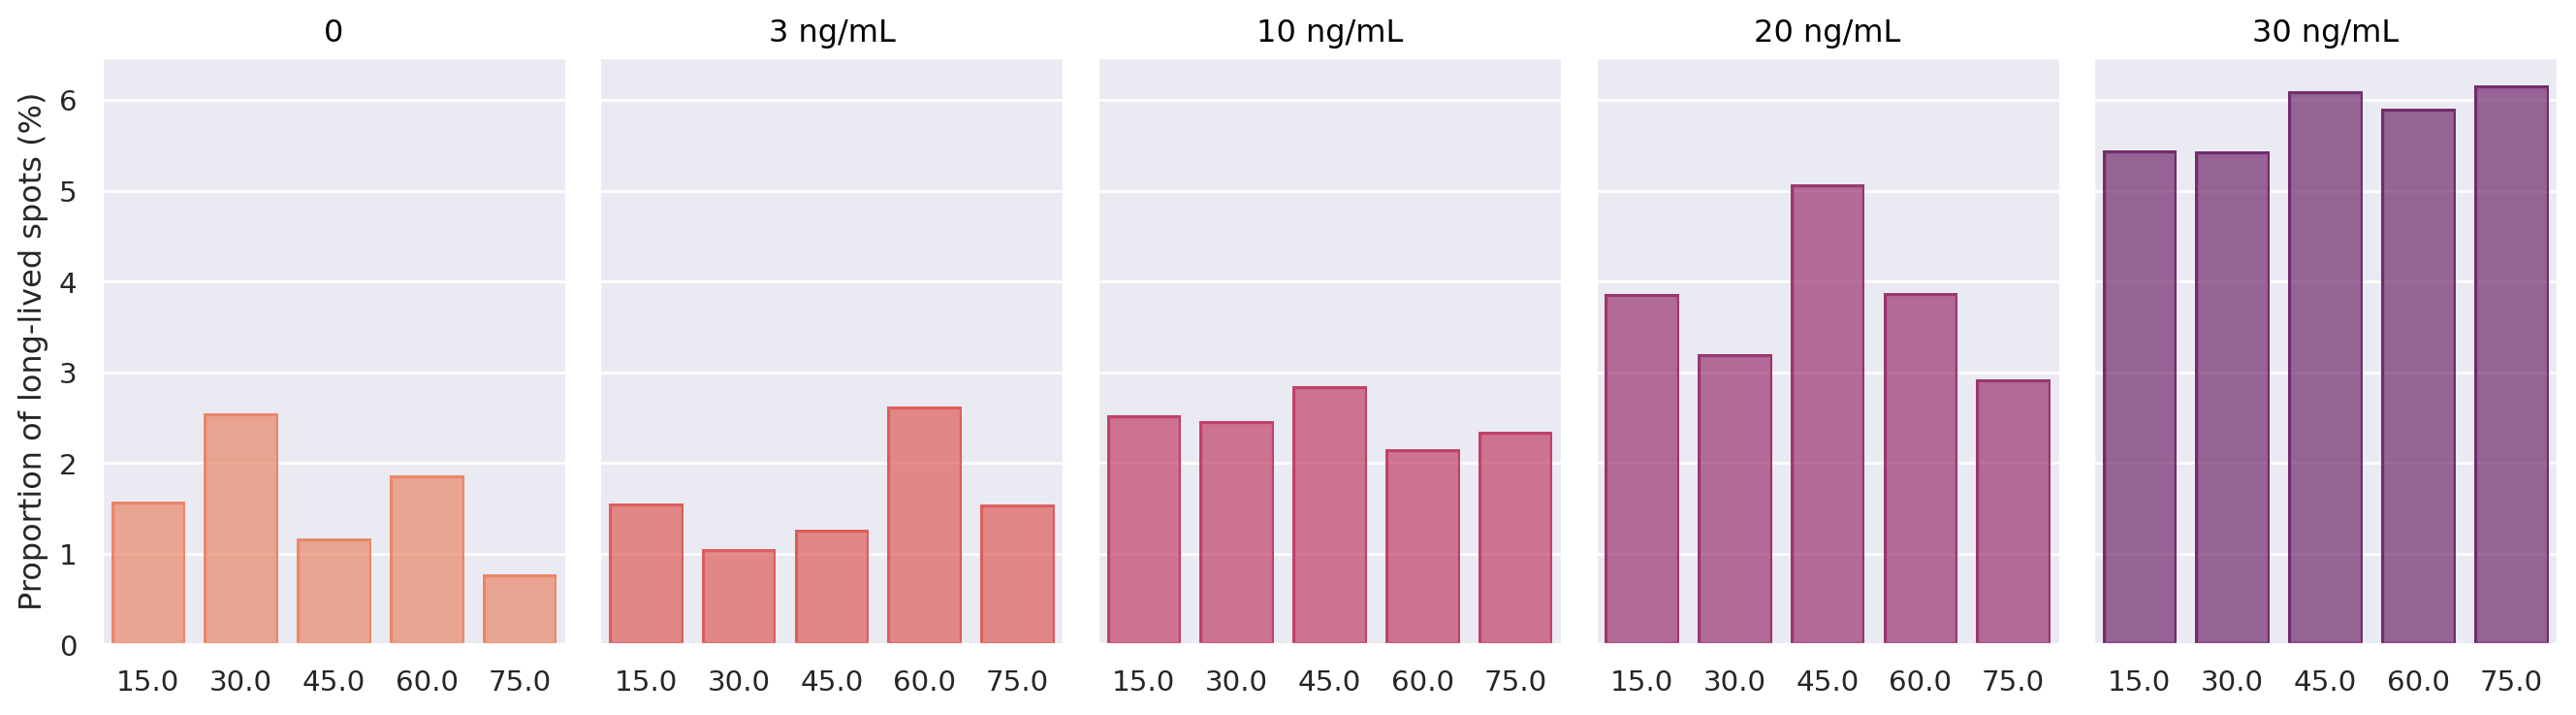

In [33]:
df = (lifetimes_timepoints
      .query('Parameter == "Population" and Rate_type == "Long"')
    #   .assign(value=lambda df: df.value - 1.71)
      )

(
    so.Plot(df, x='Time_min_bin', y='value', color='Group')
    .layout(size=(14, 4))
    .facet(col='Group')
    .add(so.Bar(), so.Agg(), legend=False)
    .scale(color='flare')
    .limit(y=(0, None))
    .label(x="", y="Proportion of long-lived spots (%)", color='Ciprofloxacin')
    # .theme(plotting_context('talk'))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Proportion_long_spots.svg', format='svg', bbox_inches='tight')
)

#### Estimate of the rate of recruitment of RecB on DNA

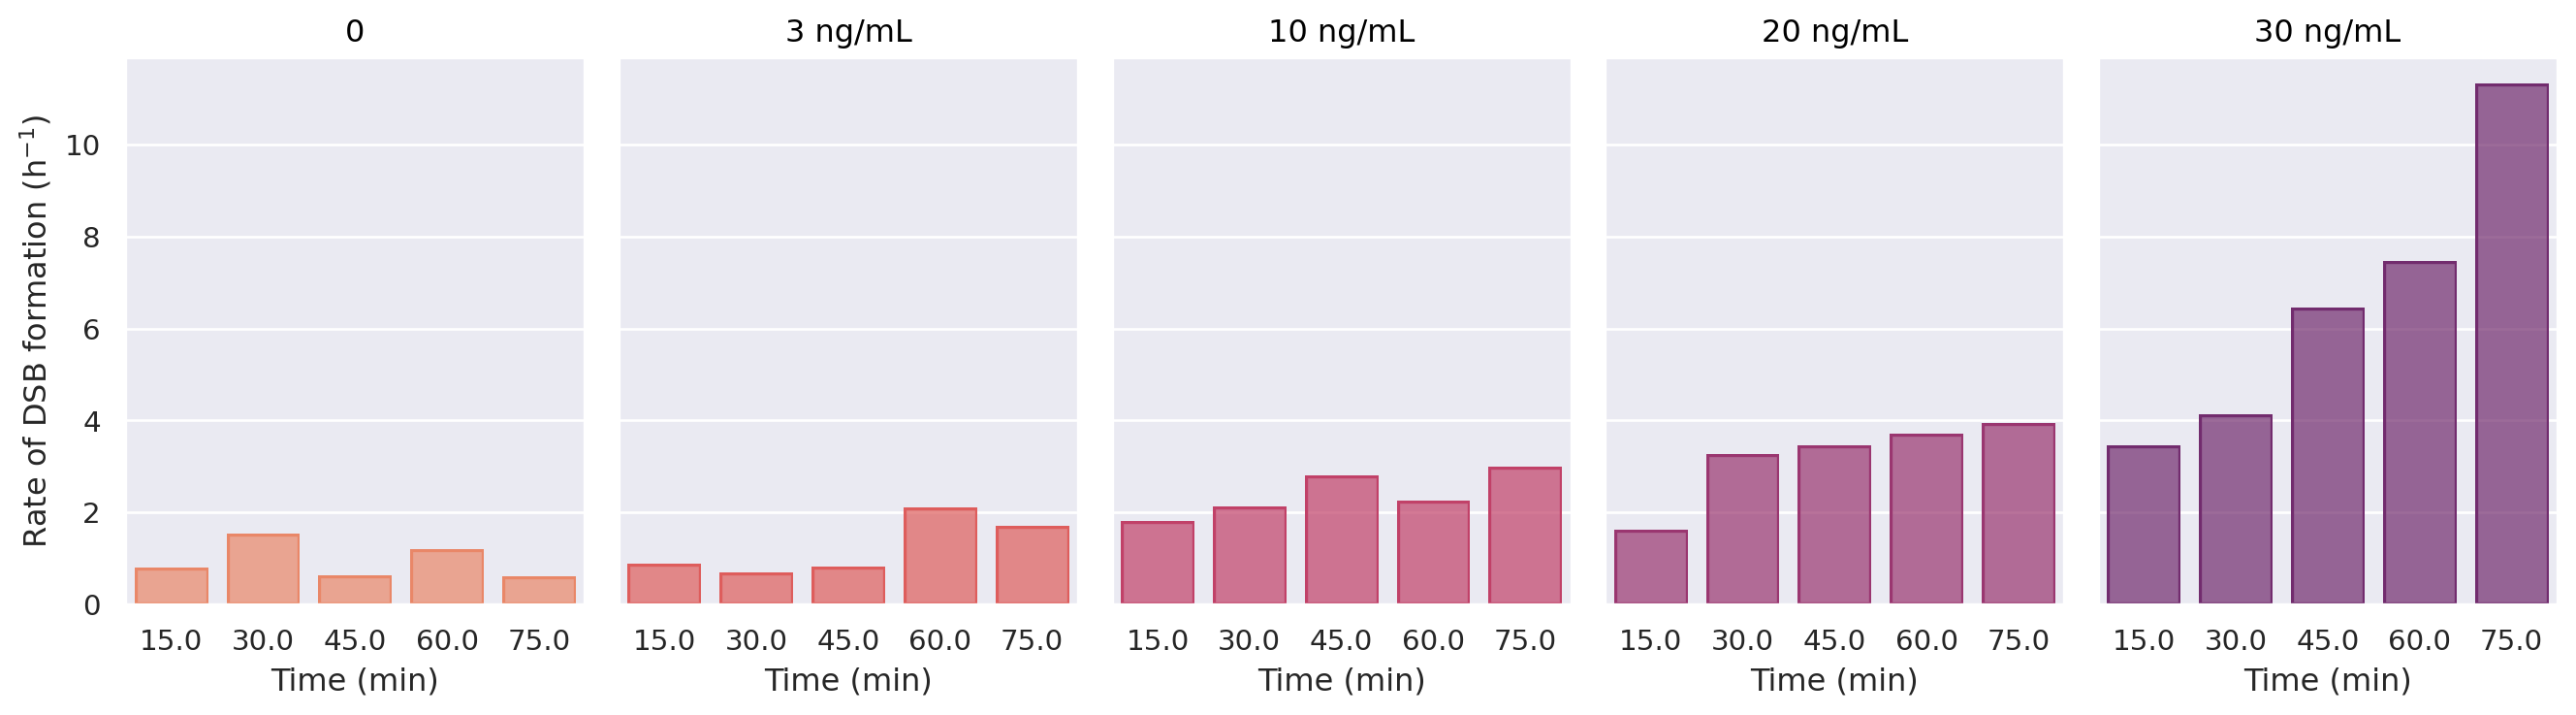

In [36]:
df = (data
      .RecB_spots
      .query('Time_min_bin < 90 and Frame > 0')
      .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('str'))
      .groupby(by=['Group', 'Time_min_bin', 'ParentIndices'], observed=True)
      .agg({'Indices': 'count'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .groupby(by=['Group', 'Time_min_bin'], observed=True)
      .agg({'SpotCount': 'sum'})
      .reset_index()
      .merge(data
             .Bacteria_large
             .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('str'))
             .groupby(['Group', 'Time_min_bin'], observed=True)
             .agg({'Position':'count'})
             .reset_index()
             .rename(columns={'Position':'nCells'}),
             how='left',
             on=['Group', 'Time_min_bin'],
             suffixes=('_old', None)
             )
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.SpotCount / df.nCells
              )
      .merge(lifetimes_timepoints
             .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('str'))
             .query('Parameter == "Population" and Rate_type == "Long"')
             .rename(columns={'value':'long_lived'})
             .assign(long_lived=lambda df: (df.long_lived)/100),
             on=['Group', 'Time_min_bin']
             )
      .assign(DSB_rate=lambda df: df.norm_count /98*60*60 *df.long_lived)  # Rate of DSB formation (h-1)
      )

(
    so.Plot(df, x='Time_min_bin', y='DSB_rate', color='Group')
    .layout(size=(14,4))
    .facet(col='Group', order=['0 ng/ml', '3 ng/ml', '10 ng/ml', '20 ng/ml', '30 ng/ml'])
    .add(so.Bar(), so.Agg(), legend=False)
    .scale(color=so.Nominal('flare', order=['0 ng/ml', '3 ng/ml', '10 ng/ml', '20 ng/ml', '30 ng/ml']))
    .limit(y=(0, None))
    .label(x="Time (min)", y="RecB recruitment rate (h$^{-1}$)", color='Ciprofloxacin')
    # .theme(plotting_context('talk'))
#     .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/DSB_rate.svg', format='svg', bbox_inches='tight')
)